# EXPLORING CORRELATIONS BETWEEN GENERAL PROPERTIES OF LIGAND BINDING SITES

### IMPORTING NECESSARY PACKAGES

In [1]:
from fragsys_analysis import *

In [4]:
main_dir = "/Users/2394007/Documents/PHD/LOCAL/FRAGSYS_DEF/"
results_dir = os.path.join(main_dir, "results/new")
all_prots = pd.read_pickle(os.path.join(results_dir, "all_prots.pkl"))
all_bs_ress = pd.read_pickle(os.path.join(results_dir, "all_bs_ress.pkl"))
all_bss = pd.read_pickle(os.path.join(results_dir, "all_bss.pkl"))

In [5]:
def get_rsa_profiles_LOC(bss_df, ress_df):
    """
    Returns a dictionary containint the binding site IDs as keys,
    and the site RSA profile as value. This is a list containing
    the RSA values of the residues forming the site.
    """
    prots = bss_df.protein.unique().tolist()
    rsa_profs = {}
    #rsa_profs_lens = []
    for prot in prots:
        prot_groups = sorted(bss_df.query('protein == @prot').group.unique().tolist())
        for group in prot_groups:
            prot_group_ress = ress_df.query('protein == @prot & group == @group')
            if len(prot_group_ress) == 0:
                print("Group {} of {} has 0 residues. Skipping!".format(group, prot))
                continue
            prot_bs_ids = sorted(bss_df.query('protein == @prot & group == @group').bs_id.unique().tolist())
            for prot_bs_id in prot_bs_ids:
                prot_bs_ress = prot_group_ress[prot_group_ress[prot_bs_id] == 1]
                prot_bs_ress = prot_bs_ress.drop_duplicates(["protein", "UniProt_ResNum", "UniProt_ResName"])
                #rsa_profs_lens.append(len(prot_bs_ress))
                if len(prot_bs_ress) == 0:
                    print("0 res at {} of group {} of {}".format(prot_bs_id, group, prot))
                    continue
                bs_rsas = prot_bs_ress.RSA.tolist()
                dk = "{}_{}_{}".format(prot, group, prot_bs_id)
                rsa_profs[dk] = sorted([round(el, 1) for el in bs_rsas])
    return rsa_profs#, rsa_profs_lens

In [8]:
rsa_profs = get_rsa_profiles_LOC(all_bss, all_bs_ress)
average_rsas = [statistics.median(v) for v in rsa_profs.values()]
all_bs_ress_filt = all_bs_ress.drop_duplicates(["protein", "UniProt_ResNum", "UniProt_ResName"])

In [9]:
print("Number of proteins: {}".format(len(all_prots.acc.unique().tolist())))
print("Number of structures: {}".format(all_prots.n_strucs.sum()))
print("Number of ligands of interest: {}".format(all_prots.n_ligs.sum()))
print("Number of defined binding sites: {}".format(all_prots.n_bs.sum()))
print("Number of binding site residues: {}".format(len(all_bs_ress_filt)))

Number of proteins: 35
Number of structures: 1309
Number of ligands of interest: 1601
Number of defined binding sites: 292
Number of binding site residues: 2664


## PRE-PROCESSING FOR THE REGRESSION + BOX PLOTS

In [10]:
binns3 = [
    (1, 6), (6, 9), (9, 11), (11, 13),
    (13, 16), (16, 21), (21, 41)
]

In [11]:
all_bss["lab"] = all_bss.protein + "_" + all_bss.group.astype(str) + "_" + all_bss.bs_id

In [12]:
all_bss_filt = all_bss.copy()[all_bss.lab.isin(rsa_profs.keys())]
all_bss_filt.index = range(len(all_bss_filt))

In [13]:
bins_list = bin_data_points(all_bss_filt, "number_bs_res", binns3)

all_bss_filt["number_bs_res_binned"] = bins_list

all_bss_filt.number_bs_res_binned = all_bss_filt.number_bs_res_binned.astype(str)
binns3 = [str(el) for el in binns3]
un_bs_sizes = list(set(all_bss_filt.number_bs_res.tolist()))

new_x = [-0.5+0.2*(n-1) for n in un_bs_sizes]

## SITE AVERAGE RSA VS SITE SIZE

In [14]:
new_rsa_means = [statistics.mean(list(v)) for v in rsa_profs.values()]

In [15]:
X =  np.array(all_bss_filt.number_bs_res.tolist())
Y = np.array(new_rsa_means)
m, b = np.polyfit(X, Y, 1)

new_y_rsa = sorted(list(set(list(m*X+b))), reverse = True)

R = pearsonr_ci(X, Y)

r = -0.38, p = 0.0, 95% CI = [-0.47, -0.27]


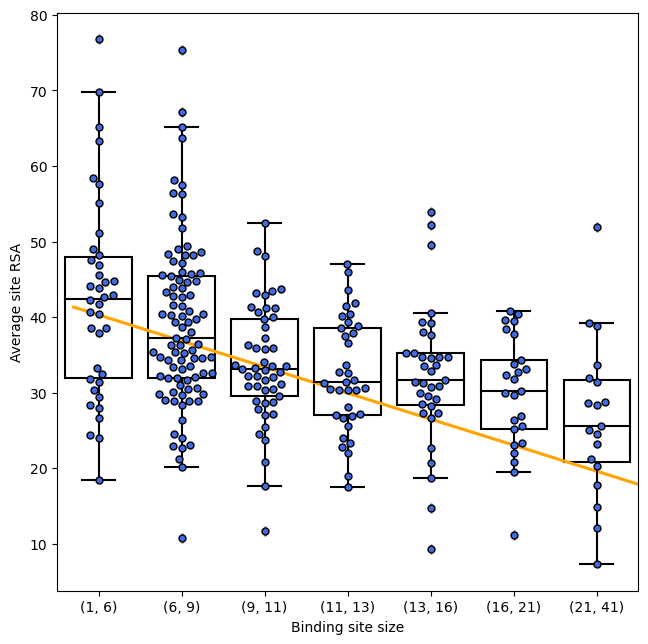

In [16]:
plot_reg_boxes(
    new_x, sorted(new_y_rsa, reverse = True),
    all_bss_filt.number_bs_res_binned, new_rsa_means, binns3,
    xlab = "Binding site size", ylab = "Average site RSA",
    f_size = (7.5, 7.5), dpi = 100, out = None, show = True)

## SITE AVERAGE DIVERGENCE VS SITE SIZE

In [17]:
reg_y_shenkin = regression_coordinates(all_bss_filt, "number_bs_res", "norm_shenkin_rel")
new_y_shenkin = sorted(list(set(list(reg_y_shenkin))), reverse = True)

R = pearsonr_ci(all_bss_filt.number_bs_res, all_bss_filt.norm_shenkin_rel)

r = -0.21, p = 0.0003, 95% CI = [-0.32, -0.1]


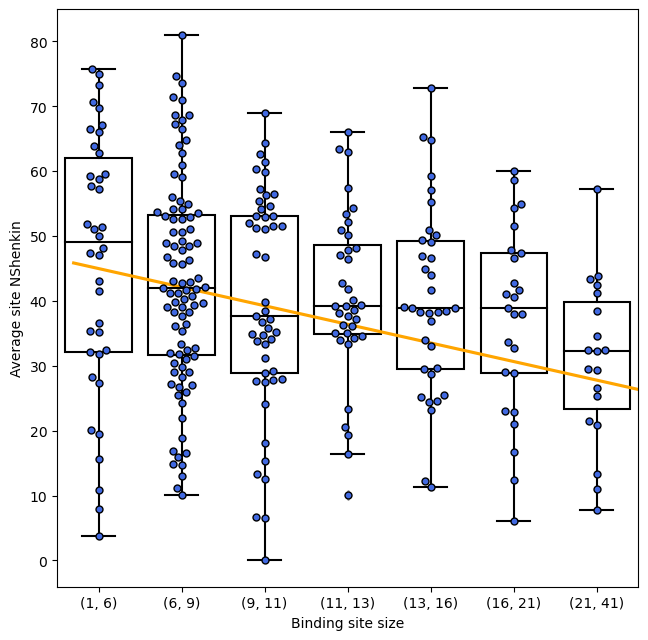

In [18]:
plot_reg_boxes(
    new_x, sorted(new_y_shenkin, reverse = True),
    all_bss_filt.number_bs_res_binned, all_bss_filt.norm_shenkin_rel, binns3,
    xlab = "Binding site size", ylab = "Average site NShenkin",
    f_size = (7.5, 7.5), dpi = 100, out = None, show = True)

## SITE AVERAGE MES VS SITE SIZE

In [19]:
reg_y_mes = regression_coordinates(all_bss_filt, "number_bs_res", "MES")
new_y_mes = sorted(list(set(list(reg_y_mes))), reverse = True)

R = pearsonr_ci(all_bss_filt.number_bs_res, all_bss_filt.MES)

r = -0.15, p = 0.0082, 95% CI = [-0.26, -0.04]


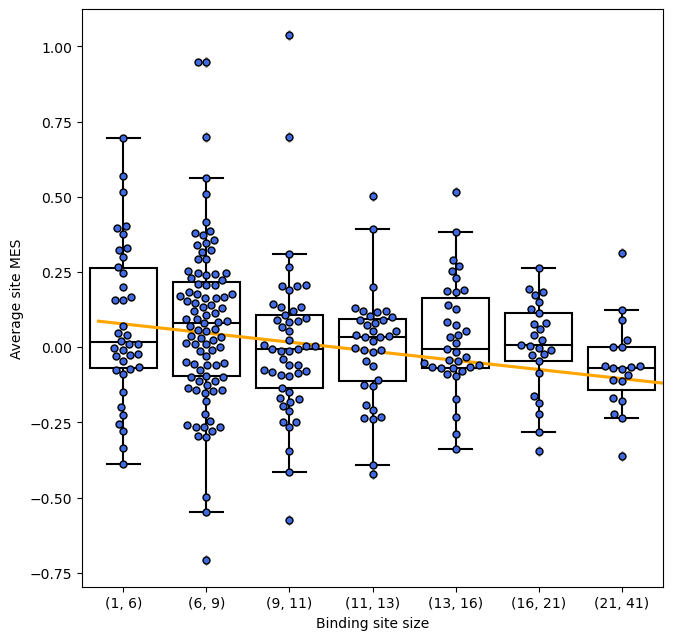

In [20]:
plot_reg_boxes(
    new_x, sorted(new_y_mes, reverse = True),
    all_bss_filt.number_bs_res_binned, all_bss_filt.MES, binns3,
    xlab = "Binding site size", ylab = "Average site MES",
    f_size = (7.5, 7.5), dpi = 100, out = None, show = True)

### NO CORRELATION BETWEEN AVERAGE SITE NSHENKIN AND MES

r = 0.0, p = 0.9547, 95% CI = [-0.11, 0.12]


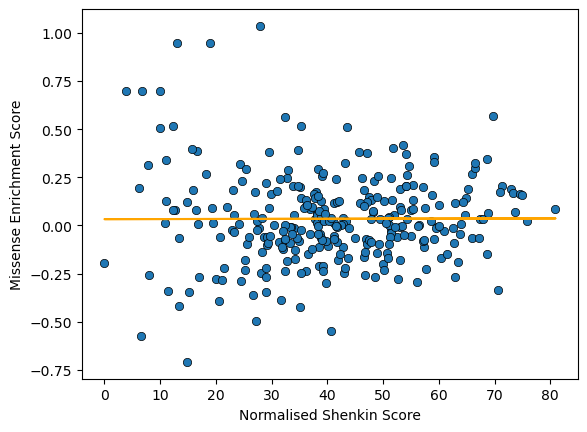

In [21]:
ezy_scatter(np.array(all_bss_filt.norm_shenkin_rel),
            np.array(all_bss_filt.MES),
            "Normalised Shenkin Score",
            "Missense Enrichment Score"
           )